# Lotka Volterra UPINN

In [1]:
import torch
import sys
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from tqdm import tqdm

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../')

from utils.BVP import BVP
from utils.UPINN import UPINN
from utils.DataGenerators import LotkaVolterra, sample_with_noise
from utils.Architectures import FNN

# torch.set_default_tensor_type('torch.cuda.FloatTensor' if torch.cuda.is_available() else 'torch.FloatTensor')

Consider the Lotka-Volterra equations, which describe the dynamics of a predator-prey system:

\begin{align}
\frac{dx}{dt} &= \alpha x - \beta x y, \\
\frac{dy}{dt} &= - \delta y + \gamma x y,
\end{align}

where $x$ is the number of prey, $y$ is the number of predators, and $\alpha$, $\beta$, $\gamma$, and $\delta$ are positive constants.

## Generate Data from System

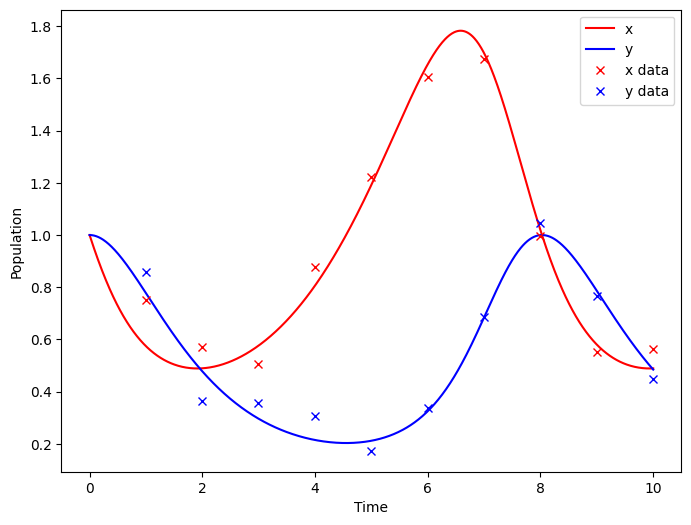

In [2]:
# Define the Lotka-Volterra system
alpha, beta, gamma, delta = 2/3, 4/3, 1.0, 1.0
x0, y0 = 1.0, 1.0

LV = LotkaVolterra(alpha, beta, gamma, delta, [x0, y0])

# Generate data
time_int = [0, 10]  # Time interval
N = 1000            # Number of points to generate
t_true = np.linspace(time_int[0], time_int[1], N).reshape(-1, 1)
U_true = LV.solve(t_true.squeeze())

# Sample subset and add noise
t_d, U_d = sample_with_noise(10, t_true, U_true, epsilon=0.1)

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(t_true, U_true[:, 0], 'r-', label='x')
plt.plot(t_true, U_true[:, 1], 'b-', label='y')
plt.plot(t_d, U_d[:, 0], 'rx', label='x data')
plt.plot(t_d, U_d[:, 1], 'bx', label='y data')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()


### Setup Boundary Value Problem

Assume that $-\beta x y$ and $\gamma x y$ is not known, and we want to learn them from data.

In [3]:
# Known dynamics
a = torch.nn.Parameter(torch.tensor([1.0], dtype=torch.float32))
d = torch.nn.Parameter(torch.tensor([1.0], dtype=torch.float32))
def F(U):
    x, y = U[:, 0], U[:, 1]
    return torch.stack([a*x, -d*y], dim=1)

U0 = np.array([x0, y0]).reshape(1, 2)
t0 = np.array([0.0]).reshape(1, 1)

### Get collocation points for $t \in [0, 10]$

In [4]:
t_c = np.linspace(0, 10, 10**3).reshape(-1, 1)

### Setup UPINN

In [5]:
# Surrogate network
hidden = [16] * 4
u = FNN(
    dims=[1, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.ReLU(),
)

# Unknown dynamics network
G = FNN(
    dims=[2, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

# Add scaling layers to the networks
u.scale_fn = lambda t_: (t_-t_d.min())/(t_d.max()-t_d.min())
mu, sigma = 0, 2
epsilon = 1e-8
G.scale_fn = lambda x: (x-mu)/(sigma+epsilon)

## Train UPINN

In [6]:
optimizer = torch.optim.Adam([*u.parameters(), *G.parameters(), a, d], lr=3e-3, weight_decay=1e-10)
device = 'cpu'

# Move to device
u.to(device), G.to(device)
t0 = torch.tensor(t0, dtype=torch.float32, device=device)
U0 = torch.tensor(U0, dtype=torch.float32, device=device)
t_d = torch.tensor(t_d, dtype=torch.float32, device=device)
U_d = torch.tensor(U_d, dtype=torch.float32, device=device)
t_c = torch.tensor(t_c, dtype=torch.float32, device=device).requires_grad_(True)

num_epochs = 10000
epoch_iterator = tqdm(range(num_epochs), desc='Epoch')

lam_pde = 1.0

for epoch in epoch_iterator:

    if epoch % 1000 == 0:
        lam_pde = 10.0

    optimizer.zero_grad()
    
    # Initial condition
    ic_loss = torch.mean((u(t0) - U0)**2)

    # Data loss
    data_loss = torch.mean((u(t_d) - U_d)**2)

    # PDE loss
    U_c = u(t_c)
    dUdt = torch.cat([torch.autograd.grad(outputs=U_c[:, i], inputs=t_c, grad_outputs=torch.ones_like(U_c[:, i]), create_graph=True)[0] for i in range(U_c.shape[1])], dim=-1)
    pde_loss = torch.mean((dUdt - F(U_c) - G(U_c))**2)

    # Total loss
    loss = ic_loss + data_loss + lam_pde*pde_loss

    # Optimization step
    loss.backward()
    optimizer.step()

    # Logging
    epoch_iterator.set_postfix({
        'Total Loss': loss.item(),
        'IC Loss': ic_loss.item(),
        'Data Loss': data_loss.item(),
        'PDE Loss': pde_loss.item(),
    })


Epoch: 100%|██████████| 10000/10000 [01:39<00:00, 100.49it/s, Total Loss=0.0922, IC Loss=9.03e-5, Data Loss=0.039, PDE Loss=0.00531]  


### Plot results

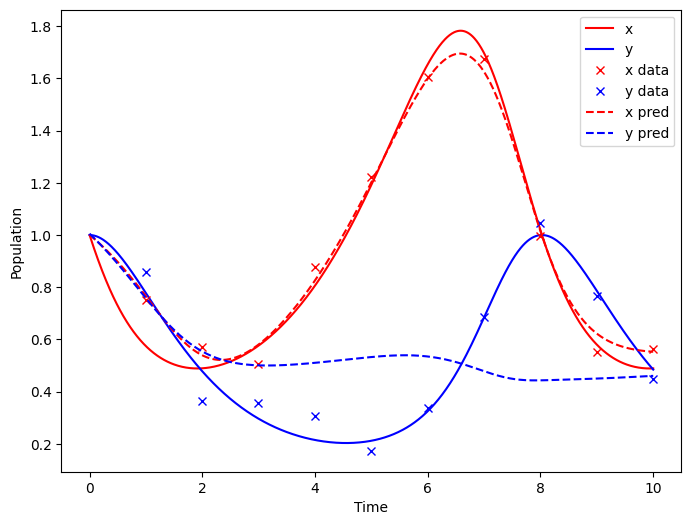

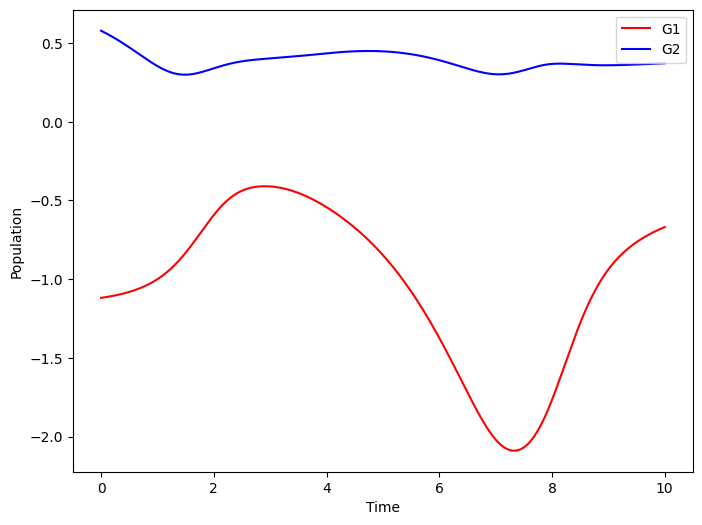

In [7]:
t_eval = np.linspace(0, 10, 10**3).reshape(-1, 1)
t_eval = torch.linspace(0, 10, 10**3).reshape(-1, 1)
U_pred = u(t_eval).detach().numpy()

plt.figure(figsize=(8, 6))
plt.plot(t_true, U_true[:, 0], 'r-', label='x')
plt.plot(t_true, U_true[:, 1], 'b-', label='y')
plt.plot(t_d, U_d[:, 0], 'rx', label='x data')
plt.plot(t_d, U_d[:, 1], 'bx', label='y data')
plt.plot(t_eval, U_pred[:, 0], 'r--', label='x pred')
plt.plot(t_eval, U_pred[:, 1], 'b--', label='y pred')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

# Plot G
U_c = u(t_c)
G_pred = G(U_c).detach().numpy()

plt.figure(figsize=(8, 6))
plt.plot(t_c.detach(), G_pred[:, 0], 'r-', label='G1')
plt.plot(t_c.detach(), G_pred[:, 1], 'b-', label='G2')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

In [8]:
d

Parameter containing:
tensor([0.8072], requires_grad=True)

## Find symbolic expression for unknown terms

In [9]:
# Generate data from the solution network
t = np.linspace(0, 10, 1000).reshape(-1, 1)
X = u(torch.tensor(t, dtype=torch.float32)).detach().numpy()
X_dot = G(torch.tensor(X, dtype=torch.float32)).detach().numpy()

# Split data into training and test set
train_test_split = 0.8
train_idx = np.arange(0, int(train_test_split*len(t)))
test_idx = np.arange(int(train_test_split*len(t)), len(t))

In [26]:
# Define SINDy library
lib = ps.PolynomialLibrary(degree=2)

# Generate taus to test
taus = np.linspace(0.1, 1.0, 100)

# Define time series cross-validation
n_splits = 5  # Number of splits (adjust based on data size)
split_size = len(X) // (n_splits + 1)  # Ensure proper train-test splits

mean_scores = np.zeros_like(taus)

for i, tau in enumerate(taus):
    scores = []  # Store scores for each time split

    # Perform time series cross-validation
    for split in range(n_splits):
        train_end = split_size * (split + 1)
        test_start = train_end
        test_end = test_start + split_size

        # Define train and test indices
        train_idx = np.arange(0, train_end)
        test_idx = np.arange(test_start, min(test_end, len(X)))

        # Initialize the SINDy model with the current tau
        model = ps.SINDy(
            feature_library=lib,
            optimizer=ps.STLSQ(threshold=tau),
        )

        # Fit the model on the training set
        model.fit(x=X[train_idx], t=t[train_idx], x_dot=X_dot[train_idx])

        # Score the model on the testing set
        scores.append(model.score(X[test_idx], t=t[test_idx], x_dot=X_dot[test_idx]))

    # Compute the mean score across all splits for this tau
    mean_scores[i] = np.mean(scores)

# Find the best tau
best_tau = taus[np.argmax(mean_scores)]
print(f'Best tau: {best_tau}')

# Fit the model with the best tau on the entire dataset
final_model = ps.SINDy(
    feature_library=lib,
    optimizer=ps.STLSQ(threshold=best_tau),
    feature_names=['x', 'y']
)
final_model.fit(x=X, t=t, x_dot=X_dot)
final_model.print()

C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2909090909090909) and eliminated all coefficients
  warnings.warn(
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.3) and eliminated all coefficients
  warnings.warn(
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.3090909090909091) and eliminated all coefficients
  warnings.warn(
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pysindy\optimizers\st

Best tau: 0.1181818181818182


ValueError: operands could not be broadcast together with shapes (998,1,998,3) (1,3,1) 